# Kernel Methods (Primal vs. Dual View)

In this lab we explore how kernel methods can be used on structured data as long as a kernel function can be defined on pairs of objects of data. Specifically, we will use the dynamic time-warping (DTW) kernel to perform learning on sequences. We then proceed to train a kernelized SVM with the DTW kernel on a sequence data set.

In [75]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 1. DTW Kernel

Given a metric $d: X \times X \rightarrow \mathbb{R}_{\geq 0}$ on the input space $X$, the family of *DTW Kernels* is given as:

$$ k_{\text{DTW}}(x, x') = e^{- \lambda d_{\text{DTW}}(x, x'; d)}, $$

for sequences $x, x' \in X^+ := \bigcup_{n \geq 1}{X^n}$ of lengths $|x|$ and $|x'|$. The *DTW distance metric* $d_{\text{DTW}}$ is then given by $\gamma(|x|, |x'|)$, where the helper function $\gamma$ is defined recursively via:

$$ \gamma(i, j) = \begin{cases} d(x_i, x_j') + \min\left(\gamma(i-1, j-1), \gamma(i-1, j), \gamma(i, j-1)\right) & (1 \leq i \leq |x|, \, 1 \leq j \leq |x'|), \\ 
\infty & i = 0 \vee j = 0, \\
0 & (i, j) = (0, 0). \end{cases}
$$

The intuition is that $\gamma(i, j)$ is the minimum squared distance up to time $i$ and $j$. $i = |x|$ and $j = |x'|$ are edge cases in the sense that the if a sequence has ended it cannot be matched anymore (and thus the value are infinite or the result value as both have been matched).

To compute $d_{\text{DTW}}$ the technique of <a href="https://en.wikipedia.org/wiki/Dynamic_programming" target="_blank">Dynamic Programming</a> is being used, where you store $\gamma$ in a $(|x|+1) \times (|x'|+1)$ grid.



<b>Exercise 1</b>:

Implement the function *d_DTW(x, x2, dist)*. The inputs x and x2 are the sequences to be compared and the parameter dist is a function on a pairs of points of the input space $X$ that outputs a real number (the distance between the pairs of points). Some code is given to help you dealing with the edge cases. The function is supposed to return the value of $d_{\text{DTW}}$ (The distance between x and x2) with the specified parameters, *not* the $k_{\text{DTW}}$.

입력 공간 $X$에 측정항목 $d: X \times X \rightarrow \mathbb{R}_{\geq 0}$가 주어지면 *DTW 커널* 계열은 다음과 같이 제공됩니다.

$$ k_{\text{DTW}}(x, x') = e^{- \lambda d_{\text{DTW}}(x, x'; d)}, $$

$x, x' \in X^+ := \bigcup_{n \geq 1}{X^n}$ 길이가 $|x|$ 및 $|x'|$인 시퀀스의 경우. *DTW 거리 측정법* $d_{\text{DTW}}$는 $\gamma(|x|, |x'|)$에 의해 제공됩니다. 여기서 도우미 함수 $\gamma$는 다음을 통해 재귀적으로 정의됩니다.

$$ \gamma(i, j) = \begin{cases} d(x_{i-1}, x_{j-1}') + \min\left(\gamma(i-1, j-1), \gamma(i-1, j), \gamma(i, j-1)\right) & (1 \leq i \leq |x|, \, 1 \leq j \leq |x'|), \\
\infty & i = 0 \vee j = 0, \\
0 & (i, j) = (0, 0). \end{cases}
$$

직관상 $\gamma(i, j)$는 $i$ 및 $j$까지의 최소 제곱 거리입니다. $i = |x|$ 및 $j = |x'|$는 시퀀스가 ​​종료되면 더 이상 일치할 수 없다는 의미에서 극단적인 경우입니다(따라서 값이 무한하거나 결과 값이 둘 다 일치됨). ).

$d_{\text{DTW}}$를 계산하기 위해 <a href="https://en.wikipedia.org/wiki/Dynamic_programming" target="_blank">동적 프로그래밍</a> 기술이 사용됩니다. $(|x|+1) \times (|x'|+1)$ 그리드에 $\gamma$를 저장하는 곳입니다.



<b>연습 1</b>:

*d_DTW(x, x2, dist)* 함수를 구현합니다. 입력 x와 x2는 비교할 시퀀스이고 매개변수 dist는 실수(점 쌍 사이의 거리)를 출력하는 입력 공간 $X$의 점 쌍에 대한 함수입니다. 극단적인 경우를 처리하는 데 도움이 되는 일부 코드가 제공됩니다. 이 함수는 $k_{\text{DTW}}$가 *아님* 지정된 매개변수를 사용하여 $d_{\text{DTW}}$(x와 x2 사이의 거리) 값을 반환하도록 되어 있습니다.

![](./cumulative.PNG)

In [76]:
def d_DTW(x, x2, dist):
    t1, t2 = len(x), len(x2)
    
    #Edge Cases
    
    '''
    if x == [] and x2 == []:
        return 0.0
    elif (x == []) or (x2 == []):
        return np.infty
    '''
    # this code cause problem!!
    
    if len(x) == 0 and len(x2) == 0:
        return 0.0 # 두 시퀀스가 모두 비어있는 경우 거리는 0입니다.
    elif (len(x) == 0) or (len(x2) == 0):
        return np.infty # 하나의 시퀀스만 비어있는 경우 거리는 무한대입니다.
    
     # DP 테이블 초기화. 중간결과를 저장하기 위한 데이터 스트럭쳐가 필요하다.
    dp = np.empty((t1+1, t2+1))    
    dp[0, 0] = 0    # 두 빈 시퀀스 사이의 거리는 0입니다.
    
    for i in range(1, t1+1):
        dp[i, 0] = np.infty # 첫 번째 시퀀스가 비어있는 경우 거리는 무한대이다. 따라서, 첫번째 열의 값은 무한대로 초기화한다.
    
    for j in range(1, t2+1): # 두 번째 시퀀스가 비어있는 경우 거리는 무한대이다. 따라서, 첫번째 행의 값은 무한대로 초기화한다.
        dp[0, j] = np.infty
        
    #Standard Procedure
    
    # WRITE YOUR CODE HERE
    
    # 테이블을 채워보도록 하자.
    
    for i in range(1, t1+1):
        for j in range(1, t2+1):
            dp[i,j] = dist(x[i-1], x2[j-1]) + min(dp[i-1, j], dp[i, j-1], dp[i-1, j-1])
    
    
    return dp[t1, t2]

Check your solution:

In [77]:
try:
    assert d_DTW([1, 2, 3, 3], [1, 2, 3], lambda x, y: 1 if x != y else 0) == 0.0
    assert d_DTW([1, 2, 3, 4], [1, 2, 3], lambda x, y: 1 if x != y else 0) == 1.0
    assert d_DTW([1, 2, 3, 2], [1, 2], lambda x, y: 1 if x != y else 0) == 1.0
    assert d_DTW([], [1, 2], lambda x, y: 1 if x != y else 0) == np.infty
    assert d_DTW([], [], lambda x, y: 1 if x != y else 0) == 0.0
    print("There is no error in your function!")
except AssertionError:
    print("There is an error in your function!")

There is no error in your function!


We define three distance functions on two values $x, x' \in X$:

$d_1(x_2, x_2) = \mathbb{1}[x_1 != x_2]$, (a boolean Value should be returned)

$d_2(x_1, x_2) = (x_1 - x_2)^2$,

$d_3(x_1, x_2) = |x_1 - x_2|$,

Optional: $d_4(\Delta x_i, \Delta x'_i) = (\Delta x_i - \Delta x'_i)^2$, with
$$ \Delta x_i = \frac{1}{2}\left( x_i - x_{i-1} + \frac{x_{i+1} - x_{i-1}}{2}\right) $$
as *approximate derivates of order 2*. Note that the edge cases are $\Delta x_1 = 0$ and $\Delta x_{|x|} = x_{|x|} - x_{|x|-1}$. 

*Hint*: It's best to map the sequences $x = (x_1, \dots, x_{|x|})$ to $\Delta x = \left(\Delta x_1, \dots, \Delta x_{|x|}\right)$ and then apply $d_2$.

<b>Exercise 2</b>:

Implement the missing distance metrics.


In [78]:
def d1(x, x2):
    return 1.0 if x != x2 else 0.0

def d2(x, x2):
    return (x - x2) ** 2

def d3(x, x2):
    return np.abs(x - x2)

def d4(x,x2):
    return None 

The following code lifts the distance metrics to maps that map a given hyperparameter $\lambda$ return the corresponding kernel function $k_{\text{DTW}}$.

다음 코드는 주어진 하이퍼파라미터 $\lambda$를 매핑하는 맵으로 거리 측정항목을 리프트하여 해당 커널 함수 $k_{\text{DTW}}$를 반환합니다.

$$ k_{\text{DTW}}(x, x') = e^{- \lambda d_{\text{DTW}}(x, x'; d)}, $$

In [79]:
k1_hyp, k2_hyp, k3_hyp = [lambda lmbd: (lambda x, x2: np.exp(-lmbd * d_DTW(x, x2, d))) for d in [d1, d2, d3]]

# d함수들은 두 시퀀스 간의 거리를 측정한다.
# 각 거리함수 d에 대해 하이퍼파라미터 lmbd를 받아서, dtw 함수를 계산하고, 지수함수를 이용하여 커널함수로 변환한 후 반환한다.

In [80]:
# 각 거리에 대해 하이퍼파라미터 lmbd를 2.0으로 설정, 인자로 받아 DTW커널함수를 생성한다.

k1 = k1_hyp(2.0) # d1을 사용하는 DTW 커널함수
k2 = k2_hyp(2.0)
k3 = k3_hyp(2.0)

The following code computes the Gram matrix $K$ with respect to the kernel $k$ (a parameter) and the data $xs$ (another parameter), see slide 28 and 29 in Kernel Methods lecture.

다음 코드는 커널 $k$(매개변수) 및 데이터 $xs$(다른 매개변수)와 관련하여 그람 행렬 $K$를 계산합니다. 커널 방법 강의 슬라이드 28 및 29를 참조하세요.

In [81]:
def build_dtw_gram_matrix(xs, x2s, k):
    """
    xs: collection of sequences (vectors of possibly varying length)
    x2s: the same, needed for prediction
    k: a kernel function that maps two sequences of possibly different length to a real
    The function returns the Gram matrix with respect to k of the data xs.
    
    데이터집합 xs에 대한 커널함수 k의 그람행렬을 반환한다. xs는 시퀀스들의 컬렉션, 각 시퀀스는 길이가 서로 다를 수 있다.
    x2s는 예측을 위해 필요한 동일한 형태의 시퀀스 컬렉션이다.
    k는 커널함수!
    """
    t1, t2 = len(xs), len(x2s)
    K = np.empty((t1, t2))
    
    for i in range(t1):
        for j in range(i, t2): # i부터 t2까지, 위 삼각행렬만 채운다.
            K[i, j] = k(xs[i], x2s[j]) # 커널함수를 이용하여 xs와 x2s사이의 값을 계산하여 할당.
            if i < t2 and j < t1: # 대칭성 유지
                K[j, i] = K[i, j]
        
    return K
    

In [82]:
build_dtw_gram_matrix([[1, 2], [2, 3]], [[1, 2, 3], [4]], k1)

array([[1.35335283e-01, 4.53999298e-05],
       [4.53999298e-05, 2.47875218e-03]])

## 2. Kernel SVM

Now we implement the training algorithm for kernel SVMs. We adjust the ERM learning algorithm from the linear classification lab. First we are reusing the code for the $\mathcal{L}_2$-regularizer and the hinge loss.

이제 커널 SVM에 대한 훈련 알고리즘을 구현합니다. 선형 분류 연구실에서 ERM 학습 알고리즘을 조정합니다. 먼저 $\mathcal{L}_2$-regularizer 및 힌지 손실에 대한 코드를 재사용합니다.

In [83]:
# 커널 SVM은 힌지loss와 l2 regularizer를 사용한다.

def L2_reg(w, lbda):
    return 0.5 * lbda * (np.dot(w.T, w)), lbda*w 

def hinge_loss(h, y):
    n = len(h)
    l = np.maximum(0, np.ones(n) - y*h)
    g = -y * (h > 0)
    return l, g

<b>Exercise 3</b>:

Adjust the old code (Lab 06) to actually learn the kernel linear regression. Note that there is a new parameter $k$ that encodes the kernel function. Note that lbda is not the $\lambda$ used in the definition of $k$, but the regularization coefficient (as before). Note also that the learning rate $\alpha$ has been renamed to $\eta$, because $\alpha$ coincides with the dual coefficients (see lecture).
Also make sure to return the Gram matrix $K$ together with the weight vector $w$ (or $\alpha$), as it is costly to compute and needed for the inference.

실제로 커널 선형 회귀를 학습하려면 이전 코드(Lab 06)를 조정하세요. 커널 함수를 인코딩하는 새로운 매개변수 $k$가 있습니다. lbda는 $k$ 정의에 사용된 $\lambda$가 아니라 정규화 계수(이전과 마찬가지로)입니다. 또한 학습률 $\alpha$는 $\eta$로 이름이 바뀌었습니다. $\alpha$가 이중 계수와 일치하기 때문입니다(강의 참조).
또한 계산 비용이 많이 들고 추론에 필요하므로 가중치 벡터 $w$(또는 $\alpha$)와 함께 그램 행렬 $K$를 반환해야 합니다.

In [84]:

def learn_reg_kernel_ERM(X, y, lbda, k, loss=hinge_loss, reg=L2_reg, max_iter=200, tol=0.001, eta=1., verbose=False):
    """Kernel Linear Regression (default: kernelized L_2 SVM)
    X -- data, each row = instance
    y -- vector of labels, n_rows(X) == y.shape[0]
    lbda -- regularization coefficient lambda
    k -- the kernel function
    loss -- loss function, returns vector of losses (for each instance) AND the gradient
    reg -- regularization function, returns reg-loss and gradient
    max_iter -- max. number of iterations of gradient descent
    tol -- stop if norm(gradient) < tol
    eta -- learning rate
    """
    num_features = X.shape[1]
    
    g_old = None # gradient from the previous iteration
    
    K = build_dtw_gram_matrix(X,X,k) # MODIFY; fill in; hint: use gram matrix defined above
    alpha = np.random.randn(K.shape[0]) # modify; hint: The matrix K should be used and w has as many entries as training examples. 
    # dual: w -> alpha
    
    for t in range(max_iter):
        h = np.dot(K.T,alpha) # MODIFY; hint: see slide 20,21, and 35 (primal vs. dual view) 
        # inner product of X and theta -> inner product of K and alpha
        l,lg = loss(h, y) # hinge loss
        
        if verbose:
            print('training loss: ' + str(np.mean(l)))
            
        r,rg = reg(alpha, lbda) # l2 regularization
        g = lg + rg  # gradient, minimization of this gradient is the goal
        
        if g_old is not None:
            eta = 0.9**t  # 에타는 스텝사이즈이다.
            #eta = eta*(np.dot(g_old.T,g_old))/(np.dot((g_old - g).T, g_old)) # 
            
        # 안정성: 초기에는 높은 학습률을 사용하여 빠르게 학습할 수 있지만, 학습이 진행될수록 학습률을 낮추면 보다 안정적으로 수렴할 수 있습니다. 학습률이 너무 높으면 최소값을 놓치거나 진동할 수 있으며, 학습률을 점진적으로 낮추면 이러한 문제를 줄일 수 있습니다.
            
        alpha = alpha - eta*g # gradient descent step
        if (np.linalg.norm(eta*g)<tol):
            break
        g_old = g
        
    return alpha, K




The adjusted inference function is given as (for binary classification):

In [85]:
def predict(alpha, X, X_train, k):
    K = build_dtw_gram_matrix(X_train, X, k)
    y_pred = np.dot(K, alpha)
    y_pred[y_pred >= 0] = 1
    y_pred[y_pred < 0] = -1
    
    return y_pred

## 3. DTW Kernel SVM in Action

Now we put our results from section $1$ and $2$ together to use a kernelized SVM for a classification task on sequence data.

In [86]:
import os
from scipy.io import loadmat # for matlab *.mat format, for modern once need to install hdf5

file_path = "laser_small.mat" # file path for multi os support
mat = loadmat(file_path)

X = mat['X']
y = mat['Y'].reshape(50)

print(X.shape, y.shape)
print(y)

(50, 60) (50,)
[-1  1 -1  1  1  1 -1  1 -1  1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1  1 -1
  1  1 -1 -1  1  1 -1 -1  1 -1  1 -1  1 -1 -1  1 -1 -1 -1  1 -1  1  1 -1
 -1 -1]


We have only 50 training instances and thus only go for a simple train-test-split (we cannot afford a simple train-val-test-split). If we try several kernels, we are actually tuning a hyperparameter and thus are fitting on the test set. The solution to this problem would be the nested cross-validation procedure, which we learn in the evaluation lecture.

In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(X_train.shape, X_test.shape)
print(X_train,y_train)

(33, 60) (17, 60)
[[30.9772   24.951    30.7112   ...  9.5712    3.69343   6.59807 ]
 [27.2873   35.6034   32.7002   ... 19.0453   13.9377   16.0668  ]
 [31.6969   28.1591   25.4696   ... 17.2545   13.6749   19.7571  ]
 ...
 [33.2066   31.0572   31.0873   ... 22.6525   24.0369   18.5095  ]
 [33.417    27.9357   33.7458   ...  2.43136   0.981456  7.4029  ]
 [26.529    28.9472   27.3931   ... 18.8145   16.2135   20.5375  ]] [ 1 -1 -1  1 -1  1  1 -1 -1 -1 -1 -1  1  1  1  1  1 -1 -1  1 -1 -1 -1 -1
  1  1 -1 -1  1 -1 -1  1 -1]


In [88]:
alpha, K = learn_reg_kernel_ERM(X_train, y_train, lbda=1, k=k2, max_iter=20000, eta=1, tol=1e-3, verbose=True)

training loss: 0.9268732434010152
training loss: 0.5454545454545454
training loss: 0.5727272727272726
training loss: 0.5751818181818182
training loss: 0.5756015454545453
training loss: 0.5757039169363636
training loss: 0.5757356019337012
training loss: 0.5757472797246349
training loss: 0.5612583588307274
training loss: 0.5674997962884125
training loss: 0.57069902924841
training loss: 0.5724628353543991
training loss: 0.5734967598042818
training loss: 0.5741352810060395
training loss: 0.5745476465652803
training loss: 0.5748244395554537
training loss: 0.5750165640245071
training loss: 0.5751538749946623
training loss: 0.5752545552678158
training loss: 0.5753300559447733
training loss: 0.5753878075321195
training loss: 0.5754327627159443
training loss: 0.5754683034306165


And evaluation of the model.

In [89]:
y_pred = predict(alpha, X_train, X_train, k2)
print("Training Accuracy: {}".format(np.mean(y_train == y_pred)))
print("Test Accuracy: {}".format(np.mean(y_test == predict(alpha,X_train, X_test, k2))))
print("Shape of alpha {}".format(alpha.shape))

Training Accuracy: 0.9696969696969697
Test Accuracy: 0.8823529411764706
Shape of alpha (33,)


We see that the training accuracy is far better than the test accuracy. This *could* - but does not have to - mean that we are overfitting.

Vary the choices of the kernel functions, regularization parameters and kernel smoothing parameters (the $\lambda$ in the definition of $k_{\text{DTW}}$). In the rest of the notebook you learn how you can draw learning curves we have discussed in the tutorial. To be able to use the helper function, the estimator needs to be wrapped in a scikit-learn conform way. You can find and use the example class KernelEstimator.

In [90]:
#from sklearn.learning_curve import learning_curve
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1,
                        train_sizes=10, # list of floats that describe ratio of test data sets tried
                        # OR an int = # how many trials
                        scoring=None):

    if type(train_sizes) == int:
        train_sizes=np.linspace(.1, 1.0, train_sizes)

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
 
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    if cv is not None:
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    if cv is not None:
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [91]:
from sklearn.base import BaseEstimator

class KernelEstimator(BaseEstimator):
    
    def __init__(self, k, lbda):
        self.k = k
        self.lbda = lbda
        
    def fit(self, X, y):
        self._X_train = X
        self._alpha, _ = learn_reg_kernel_ERM(X, y, lbda=self.lbda, k=self.k, max_iter=20000, eta=1, tol=1e-3)
        return self
    
    def predict(self, X):
        return predict(self._alpha, self._X_train, X, self.k)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y == y_pred)
        

<b>Exercise 4:</b>

Vary the choices of the kernel functions, regularization parameters and kernel smoothing parameters (the $\lambda$ in the definition of $k_{\text{DTW}}$). 

Accuracy 1.0


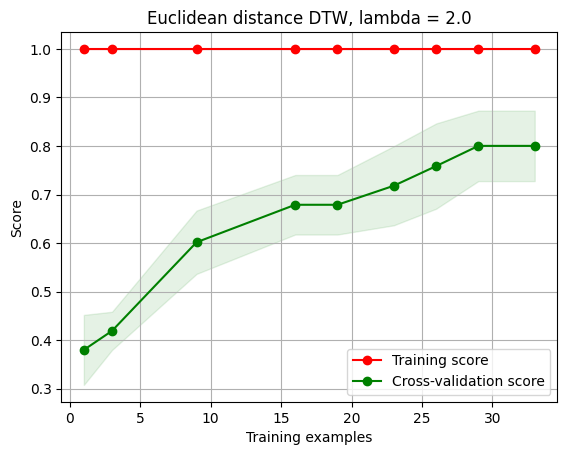

In [92]:
estimator = KernelEstimator(k1_hyp(2.0), 2.0)   # MODIFY 
estimator.fit(X_train, y_train)
print("Accuracy {}".format(estimator.score(X_train, y_train)))
plot_learning_curve(estimator, 'Euclidean distance DTW, lambda = 2.0', X, y, cv=3, scoring="accuracy", train_sizes=[0.01,0.1,0.3,0.5,0.6,0.7,0.8,0.9,1.0]);

Accuracy 1.0


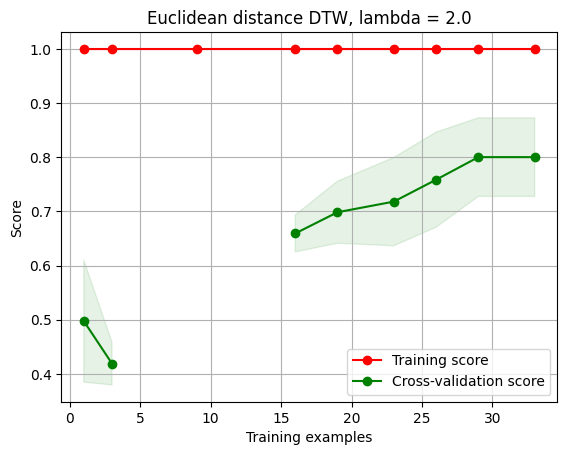

In [93]:
estimator = KernelEstimator(k2_hyp(2.0), 2.0)   # MODIFY 
estimator.fit(X_train, y_train)
print("Accuracy {}".format(estimator.score(X_train, y_train)))
plot_learning_curve(estimator, 'Euclidean distance DTW, lambda = 2.0', X, y, cv=3, scoring="accuracy", train_sizes=[0.01,0.1,0.3,0.5,0.6,0.7,0.8,0.9,1.0]);

Accuracy 1.0


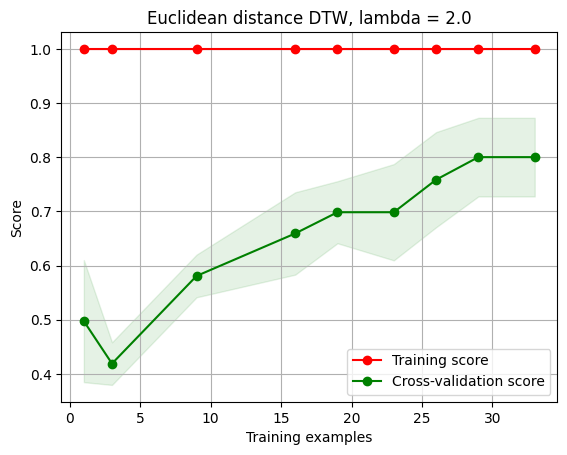

In [94]:
estimator = KernelEstimator(k3_hyp(2.0), 2.0)   # MODIFY 
estimator.fit(X_train, y_train)
print("Accuracy {}".format(estimator.score(X_train, y_train)))
plot_learning_curve(estimator, 'Euclidean distance DTW, lambda = 2.0', X, y, cv=3, scoring="accuracy", train_sizes=[0.01,0.1,0.3,0.5,0.6,0.7,0.8,0.9,1.0]);